In [1]:
import warnings

warnings.simplefilter("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd

import random
import os

import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
def moveTo( obj, device ):
    if isinstance( obj, list ):
        return [moveTo(x,device) for x in obj]
    elif isinstance( obj, tuple ):
        return tuple( moveTo( list(obj), device ) )
    elif isinstance( obj, set ):
        return set( moveTo( list(obj), device ) )
    elif isinstance( obj, dict):
        to_ret = dict()

        for key, value in obj.items():
            to_ret[ moveTo( key, device) ] = moveTo( value, device )

        return to_ret
    elif hasattr( obj, "to" ):
        return obj.to( device )
    else:
        return obj

def run_epoch( model, optimizer, data_loader, loss_func, device="cpu", results=[], score_funcs={}, prefix=" ", desc=None ):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()

    for inputs, labels in tqdm(data_loader, desc=desc, leave=False, disable=True ):
        inputs = moveTo( inputs, device )
        labels = moveTo( labels, device )

        if model.training:
            with torch.enable_grad():
                optimizer.zero_grad()
                y_hat = model( inputs )
                loss = loss_func( y_hat, labels )
                loss.backward()
                optimizer.step()
        else:
            with torch.no_grad():
                y_hat = model( inputs )
                loss = loss_func( y_hat, labels )

        running_loss.append( loss.item() )

        if len( score_funcs ) > 0 and isinstance( labels, torch.Tensor ):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()

            y_true.extend( labels.tolist() )
            y_pred.extend( y_hat.tolist() )
            
    end = time.time()

    y_pred = np.asarray(y_pred)
    
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
            
    return end-start

def train_model( model,
                 loss_func, 
                 train_loader, 
                 test_loader=None, 
                 score_funcs=None, 
                 epochs=50,
                 lr=0.001,
                 device='cpu' ):
    results = {}

    results[ "epoch" ] = []
    results[ "total time" ] = []
    results[ "train loss" ] = []

    if test_loader is not None:
        results[ "test loss" ] = []

    for eval_score in score_funcs:
        results[ "train " + eval_score ] = []
        if test_loader is not None:
             results[ "test " + eval_score ] = []

    total_train_time = 0
    
    optimizer = torch.optim.SGD( model.parameters(), lr=lr )
   
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()

        total_train_time += run_epoch( model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training" )

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            run_epoch( model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing" )

    return pd.DataFrame.from_dict( results )

def pred(model, img):
    with torch.no_grad():
        w, h = img.shape
        
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        
        x = img.reshape(1,-1,w,h)
        
        logits = model(x)

        print( logits )
        
        y_hat = F.softmax(logits, dim=1)

        print( y_hat )
    
    return y_hat

In [3]:
set_seed( seed = 5482 )

Random seed set as 5482


In [4]:
mnist_data_train = torchvision.datasets.MNIST( "./data", train=True, download=True, transform=transforms.ToTensor() )

mnist_data_test = torchvision.datasets.MNIST( "./data", train=False, download=True, transform=transforms.ToTensor() )

In [5]:
x_example, y_example = mnist_data_train[0]

type( x_example )

torch.Tensor

In [6]:
x_example.shape

torch.Size([1, 28, 28])

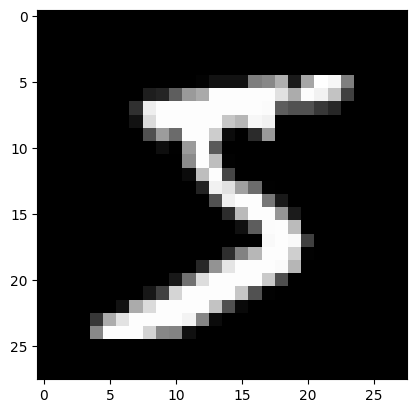

In [7]:
plt.imshow(x_example[0,:], cmap='gray' )

torch.Size([3, 28, 28])


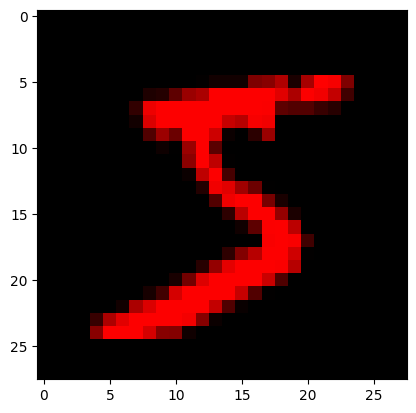

In [8]:
x_as_color = torch.stack( [x_example[0,:], x_example[0,:], x_example[0,:]], dim=0 )

print(x_as_color.shape)

#Red Channel Only
x_as_color[1,:] = 0 
x_as_color[2,:] = 0

plt.imshow(x_as_color.permute(1,2,0))

In [9]:
device = torch.device ( "cuda" if torch.cuda.is_available() else "cpu" )

print( device )

cuda


In [10]:
batch_size = 32

mnist_train_loader = DataLoader(mnist_data_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=batch_size )

In [11]:
input_channels=1
classes = 10
number_of_filters = 16
kernel_size = 3
image_dim = 28*28

padding = kernel_size//2
pool_size = 2

In [12]:
model_cnn = nn.Sequential(
                                nn.Conv2d( input_channels, number_of_filters, kernel_size, padding=padding ), # 1x28x28 => 16x28x28
                                nn.BatchNorm2d( number_of_filters ), #16x28x28 => 16x28x28
                                nn.ReLU(inplace=True), #16x28x28 => 16x28x28
                                nn.Conv2d(number_of_filters, number_of_filters, kernel_size, padding=padding ), # 16x28x28 => 16x28x28
                                nn.BatchNorm2d( number_of_filters ), #16x28x28 => 16x28x28
                                nn.ReLU(inplace=True), #16x28x28 => 16x28x28
                                nn.Conv2d(number_of_filters, number_of_filters, kernel_size, padding=padding ), # 16x28x28 => 16x28x28
                                nn.BatchNorm2d( number_of_filters ), #16x28x28 => 16x28x28
                                nn.ReLU(inplace=True), #16x28x28 => 16x28x28
                                nn.MaxPool2d(pool_size), #16x28x28 => 16x14x14
    
                                nn.Flatten(), # 16x14x14 => 3136
                                nn.Linear( 3136, classes) # 3136 => 10
                        )

In [13]:
loss_func = nn.CrossEntropyLoss()

score_funcs={ 
                'accuracy': accuracy_score
            }

epochs = 30

In [14]:
cnn_results = train_model( 
                            model_cnn,
                            loss_func, 
                            mnist_train_loader, 
                            test_loader=mnist_test_loader, 
                            score_funcs=score_funcs, 
                            device=device, 
                            epochs=epochs 
                        )

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
cnn_results.head()

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,0,39.777861,0.349956,0.152517,0.913967,0.9610
1,1,74.931519,0.138180,0.102043,0.962967,0.9734
2,2,110.313103,0.104113,0.081907,0.971650,0.9767
3,3,145.211506,0.087107,0.071588,0.976000,0.9796
4,4,180.169691,0.075964,0.062807,0.979183,0.9815


In [16]:
print( "Test Accuracy: {}".format( cnn_results[ 'test accuracy' ].iloc[-1] ) )

Test Accuracy: 0.9889


<AxesSubplot: xlabel='epoch', ylabel='test accuracy'>

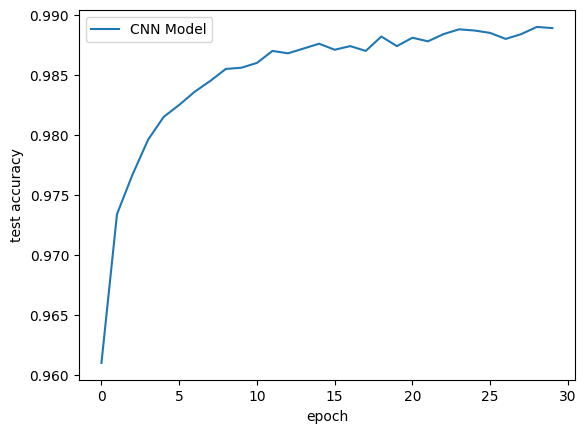

In [17]:
sns.lineplot( x='epoch', y='test accuracy', data=cnn_results, label="CNN Model" )

<AxesSubplot: xlabel='epoch', ylabel='train loss'>

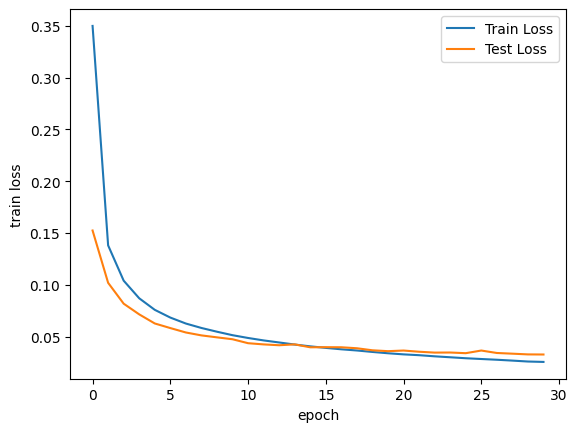

In [18]:
sns.lineplot( x='epoch', y='train loss', data=cnn_results, label="Train Loss" )
sns.lineplot( x='epoch', y='test loss', data=cnn_results, label="Test Loss" )